1. Loading the dataset

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

In [3]:
# 1.3. Load the training, validation and test datasets into a dataframes 
# Load the Parquet files into DataFrames
X_train = pd.read_parquet('../data/processed/X_train.parquet')
X_val = pd.read_parquet('../data/processed/X_val.parquet')
y_train = pd.read_parquet('../data/processed/y_train.parquet')
y_val = pd.read_parquet('../data/processed/y_val.parquet')
X_test = pd.read_parquet('../data/processed/test_cleaned.parquet')

In [4]:
# taking out the player id out of the test data
player_id_test = X_test.pop('player_id')

In [5]:
y_val = y_val.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_val.shape

(9324,)

In [6]:
y_train = y_train.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_train.shape

(37294,)

3. Support Vector Machines - Modelling

In [7]:
#3.1 Import SVM, pi and instantiate the model
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# Initialize the SVC model
svc1 = SVC(kernel='linear', probability=True)  # Set probability=True to enable probability estimates


In [8]:
# Initialize RFE with SVC
rfe = RFE(
    estimator=svc1, 
    step=1, 
    scoring='roc_auc', 
    n_jobs=-1  # Use all available CPU cores for parallel processing
)


In [9]:
# Create a pipeline with RFECV and SVC
pipeline = Pipeline([
    ('feature_selection', rfe),
    ('classification', svc)
])

In [10]:
# 3.2 Train the model and save the predicted values
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_selection',
                 RFECV(cv=5, estimator=SVC(kernel='linear', probability=True),
                       n_jobs=-1, scoring='roc_auc')),
                ('classification', SVC(kernel='linear', probability=True))])

In [13]:
# Select the probability for the positive class (class 1)
y_train_probs_svc1 = pipeline.predict_proba(X_train)[:, 1]
y_val_probs_svc1 = pipeline.predict_proba(X_val)[:, 1]

In [15]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report
# Predict class labels
y_val_pred = pipeline.predict(X_val)

# Print classification report
print(classification_report(y_val, y_val_pred))

# Print selected features
selected_features = X_train.columns[rfecv.support_]
print("Selected features:", selected_features)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9222
         1.0       0.74      0.56      0.64       102

    accuracy                           0.99      9324
   macro avg       0.87      0.78      0.82      9324
weighted avg       0.99      0.99      0.99      9324

Selected features: Index(['conf_ACC', 'conf_AE', 'conf_Amer', 'conf_B10', 'conf_B12', 'conf_BSky',
       'conf_CAA', 'conf_CUSA', 'conf_MEAC', 'conf_MVC', 'conf_MWC',
       'conf_P10', 'conf_P12', 'conf_Pat', 'conf_SB', 'conf_SEC', 'conf_Sum',
       'conf_WAC', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG', 'TS_per', 'ORB_per',
       'AST_per', 'TO_per', 'FTM', 'FTA', 'FT_per', 'twoPM', 'twoP_per', 'TPM',
       'blk_per', 'stl_per', 'ftr', 'porpag', 'pfr', 'Rec_Rank', 'ast_tov',
       'dunksmiss_dunksmade', 'pick', 'drtg', 'adrtg', 'dporpag', 'stops',
       'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm', 'dreb', 'ast',
       'stl', 'blk', 'pts'],
      dtype

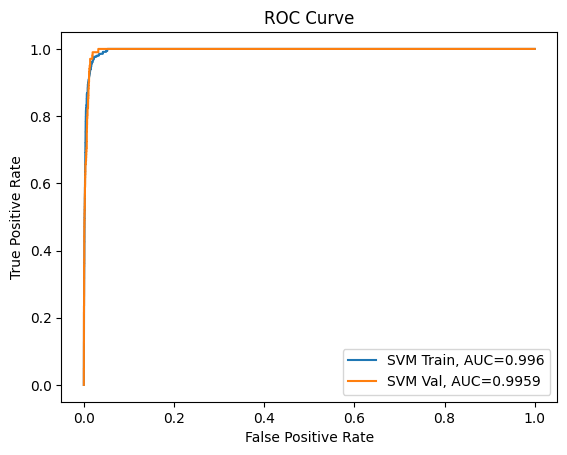

In [16]:
# 3.3 To plot ROC curve and the AUC metric - for comparison of model performances
#To plot ROC curve and the AUC metric

# Set up plotting area
plt.figure(0).clf()

# SVM - Train
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs_svc1)
auc = round(metrics.roc_auc_score(y_train, y_train_probs_svc1), 4)
plt.plot(fpr, tpr, label="SVC_RFE Train, AUC="+str(auc))

# SVM - Validation
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_probs_svc1)
auc = round(metrics.roc_auc_score(y_val, y_val_probs_svc1), 4)
plt.plot(fpr, tpr, label="SVC_RFE Val, AUC="+str(auc))

# Add legend
plt.legend()

# Show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [17]:
# 3.4 Save the probability of the test data
y_test_probs_svc1 = pipeline.predict_proba(X_test)[:, 1]


In [18]:
# 3.5 add the 'player_id'column  into the prediction probability
# Convert y_test_prob_rf3 (which is a NumPy array) to a DataFrame
y_test_probs_df = pd.DataFrame(y_test_probs_svc1, columns=['drafted'])

# Concatenate player_id_test and y_test_prob_df along the columns
Results = pd.concat([player_id_test, y_test_probs_df], axis=1)

In [19]:
Results

,player_id,drafted
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,1.000000e-07
1,52a518bb-b34a-4b43-adee-5e996cb853fa,1.212301e-04
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,6.794880e-05
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,1.365332e-06
4,55d07491-5bd1-447f-844e-9cb36eaa442e,1.073048e-04
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,1.000000e-07
4966,c32a466d-7a66-47eb-805c-a94e328261bc,3.784287e-04
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,2.718852e-07
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,1.000000e-07


In [22]:
#3.6 save the probability as CSV file

# Convert to DataFrame and save
pd.DataFrame(Results).to_csv('../data/external/SVM_RFE_Results.csv', index=False)

#3.7 save the model
# Import dump from joblib
from joblib import dump

# 3.12 Save the model and call the files respectively SVM_rfecv.joblib 
dump(svc, '../models/SVM_rfe_new.joblib')


['../models/SVM_rfecv.joblib']